In [1]:
import jsonlines
import json
from mrcad import Design, Instruction
import stanza
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import plotly.express as px

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# visual
mpl.rcParams['pdf.fonttype'] = 42
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (4,6)
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16

plt.rcParams['axes.linewidth'] = 2
plt.rcParams['patch.linewidth'] = 0

In [3]:
from PIL import Image
from io import BytesIO
import base64

In [4]:
from dotenv import dotenv_values

ENV = dotenv_values("../.env")

In [5]:
with jsonlines.open(Path(ENV["DATA_DIR"]) / "eval_verified_complete.jsonl") as reader:
    data = list(reader)

In [6]:
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse')

2025-03-01 10:40:02 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-03-01 10:40:03 INFO: Downloaded file to /home/svadugur/stanza_resources/resources.json
2025-03-01 10:40:21 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |
| depparse  | combined_charlm   |

2025-03-01 10:40:21 INFO: Using device: cuda
2025-03-01 10:40:21 INFO: Loading: tokenize
2025-03-01 10:40:22 INFO: Loading: mwt
2025-03-01 10:40:22 INFO: Loading: pos
2025-03-01 10:40:24 INFO: Loading: lemma
2025-03-01 10:40:24 INFO: Loading: depparse
2025-03-01 10:40:24 INFO: Done loading processors!


In [7]:
df_list = list()
for trial in tqdm(data):
    for rd in trial['rounds']:
        if len(rd['instruction']['text']) > 0:
            doc = nlp(rd['instruction']['text'])
            pos_tags = defaultdict(int)
            for sent in doc.sentences:
                root_verb = None
                root_verb_id = None
                root_noun = None
                root_noun_id = None
                obj_noun = None
                obj_noun_id = None
                head_id = None
                root_verb_mood = None
                for word in sent.words:
                    pos_tags[word.upos] += 1
                    if word.upos == "VERB":
                        if word.head == 0:
                            head_id = word.id
                            root_verb = word.lemma
                            root_verb_id = word.id
                            root_verb_mood = [feat.split('=')[1] for feat in word.feats.split('|') if "Mood" in feat]
                    elif word.upos == "NOUN":
                        if word.head == 0:
                            head_id = word.id
                            root_noun = word.lemma
                            root_noun_id = word.id

                for word in sent.words:
                    if word.head == head_id and word.head == root_verb_id and word.upos == "NOUN":
                        obj_noun = word.lemma
                
                df_list.append({
                    "trial_id": trial['trial_id'],
                    "round_num": rd['round_num'],
                    "round_id": f"{trial['trial_id']}/{rd['round_num']}",
                    "instruction": rd['instruction']['text'],
                    "pos_tags": dict(pos_tags),
                    "root_verb": root_verb,
                    "root_noun": root_noun,
                    "obj_noun": obj_noun,
                    "root_verb_mood": root_verb_mood
                })

df = pd.DataFrame(df_list)

100%|██████████| 2324/2324 [02:18<00:00, 16.77it/s]


In [7]:
generate_df = df[df.round_num == 1]
refine_df = df[df.round_num > 1]

In [8]:
# First, let's create the grouped DataFrame
# Instead of using count(), we'll use size() which returns a Series with the group counts
grouped_counts = generate_df[generate_df.root_verb.notnull() & generate_df.obj_noun.notnull()].groupby(["root_verb", "obj_noun"]).size()

# Convert the Series to a DataFrame and name the count column
grouped_df = grouped_counts.reset_index(name='count')

# Sort the DataFrame by the count column in descending order
sorted_df = grouped_df.sort_values(by='count', ascending=False)

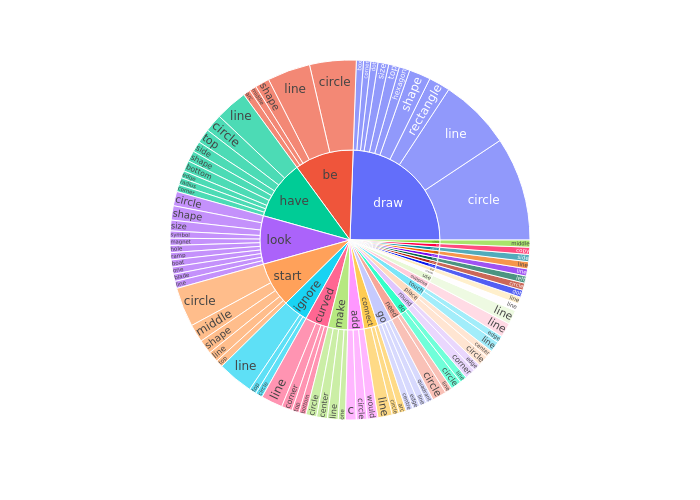

In [17]:
fig = px.sunburst(sorted_df[sorted_df['count'] > 1], path=['root_verb', 'obj_noun'], values='count')
Image.open(BytesIO(fig.to_image()))

In [18]:
# First, let's create the grouped DataFrame
# Instead of using count(), we'll use size() which returns a Series with the group counts
grouped_counts = refine_df[refine_df.root_verb.notnull() & refine_df.obj_noun.notnull()].groupby(["root_verb", "obj_noun"]).size()

# Convert the Series to a DataFrame and name the count column
grouped_df = grouped_counts.reset_index(name='count')

# Sort the DataFrame by the count column in descending order
sorted_df = grouped_df.sort_values(by='count', ascending=False)

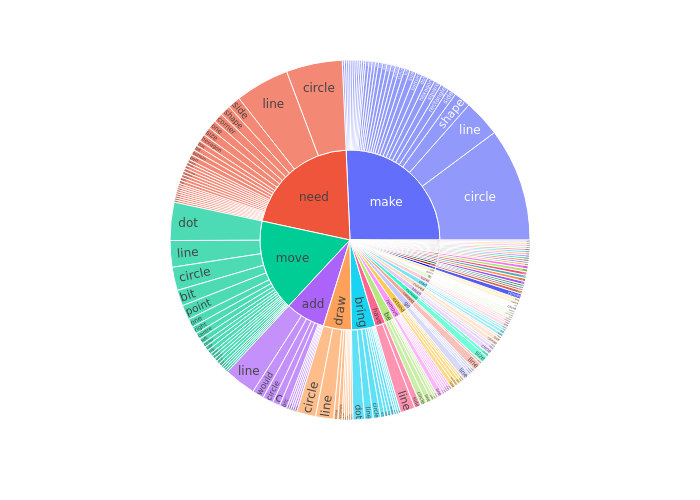

In [19]:
fig = px.sunburst(sorted_df[sorted_df['count'] > 1], path=['root_verb', 'obj_noun'], values='count')
Image.open(BytesIO(fig.to_image()))

In [20]:
df[df.root_verb.notnull()&df.obj_noun.notnull()][['trial_id', 'round_num', 'root_verb', 'obj_noun', 'round_id']].nunique()

trial_id     1332
round_num      10
root_verb     220
obj_noun      317
round_id     1952
dtype: int64

In [8]:
df[['trial_id', 'round_num', 'root_verb', 'obj_noun', 'round_id']].count()

trial_id     5615
round_num    5615
root_verb    2877
obj_noun     2305
round_id     5615
dtype: int64

In [22]:
df['round_type'] = df.round_num.apply(lambda x: "generate" if x == 1 else "refine")

In [55]:
df.groupby(['round_num', 'verb_mood']).count()

trial_id  round_id  instruction  pos_tags  root_verb  \
round_num verb_mood                                                             
1         Imp                 329       329          329       329        329   
          Ind                 312       312          312       312        312   
          none                182       182          182       182        182   
          root not verb      1402      1402         1402      1402          0   
2         Imp                 793       793          793       793        793   
          Ind                 404       404          404       404        404   
          none                183       183          183       183        183   
          root not verb       935       935          935       935          0   
3         Imp                 311       311          311       311        311   
          Ind                 108       108          108       108        108   
          none                 60        60           60        60         60   
          root not verb       281       281          281       281          0   
4         Imp                  78        78           78        78         78   
          Ind                  28        28           28        28         28   
          none                 15        15           15        15         15   
          root not verb        81        81           81        81          0   
5         Imp                  29        29           29        29         29   
          Ind                   7         7            7         7          7   
          none                  6         6            6         6          6   
          root not verb        27        27           27        27          0   
6         Imp                  17        17           17        17         17   
          none                  2         2            2         2          2   
          root not verb         7         7            7         7          0   
7         Imp                   5         5            5         5          5   
          Ind                   1         1            1         1          1   
          none                  1         1            1         1          1   
          root not verb         4         4            4         4          0   
8         Imp                   2         2            2         2          2   
          Ind                   1         1            1         1          1   
          root not verb         1         1            1         1          0   
9         Imp                   2         2            2         2          2   
10        Imp                   1         1            1         1          1   

                         root_noun  obj_noun  root_verb_mood  
round_num verb_mood                                           
1         Imp                    0       252             329  
          Ind                    0       280             312  
          none                   0       137             182  
          root not verb       1019         0               0  
2         Imp                    0       659             793  
          Ind                    0       316             404  
          none                   0       136             183  
          root not verb        456         0               0  
3         Imp                    0       245             311  
          Ind                    0        82             108  
          none                   0        46              60  
          root not verb        142         0               0  
4         Imp                    0        66              78  
          Ind                    0        15              28  
          none                   0         8              15  
          root not verb         40         0               0  
5         Imp                    0        25              29  
          Ind                    0         4               7  
          

In [25]:
df.columns

Index(['trial_id', 'round_num', 'round_id', 'instruction', 'pos_tags',
       'root_verb', 'root_noun', 'obj_noun', 'round_type'],
      dtype='object')

In [46]:
df.root_verb_mood.iloc[2]

['Imp']

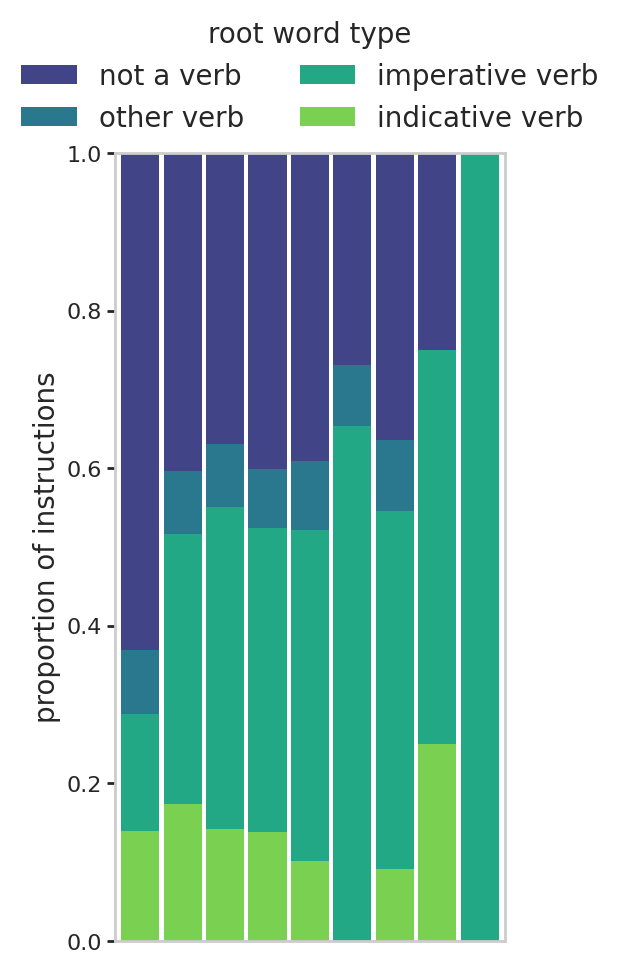

In [47]:
def categorize_root(row):
    has_verb = pd.notnull(row["root_verb"])
    has_noun = pd.notnull(row["root_noun"])

    if has_verb and has_noun:
        return "Both"
    elif has_verb:
        return "Verb Only"
    elif has_noun:
        return "Noun Only"
    else:
        return "Neither"


def get_verb_mood(row):
    if pd.notnull(row["root_verb"]):
        if len(row["root_verb_mood"]) > 0:
            return (
                "imperative verb"
                if row["root_verb_mood"][0] == "Imp"
                else (
                    "indicative verb"
                    if row["root_verb_mood"][0] == "Ind"
                    else "other verb"
                )
            )
        else:
            return "other verb"
    else:
        return "not a verb"


# Add the category column
# df['root_category'] = df.apply(categorize_root, axis=1)

df["verb_mood"] = df.apply(get_verb_mood, axis=1)

# df_filtered = df[(df.round_num <= 6)] # &(df.root_verb != "be")]

# # Calculate the crosstab of counts
# counts = pd.crosstab(df_filtered['round_num'], df_filtered['verb_mood'])

# # Calculate proportions
# props = counts.div(counts.sum(axis=1), axis=0)

# # Create a figure
# fig, ax = plt.subplots(figsize=(12, 8))

# # Plot stacked bars
# props.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')

# # Customize the plot with seaborn styling
# sns.despine(left=True)  # Remove the left spine for a cleaner look

# # Add percentage labels to the segments
# for i, (idx, row) in enumerate(props.iterrows()):
#     cumulative = 0
#     for col in props.columns:
#         if row[col] > 0.05:  # Only label segments that are large enough
#             ax.text(
#                 i,
#                 cumulative + row[col]/2,
#                 f"{row[col]:.1%}",
#                 ha='center',
#                 va='center',
#                 fontweight='bold'
#             )
#         cumulative += row[col]

# # Improve the aesthetics
# plt.title('Proportion of Root Mood by Round Number', fontsize=16)
# plt.xlabel('Round Number', fontsize=14)
# plt.ylabel('Proportion', fontsize=14)
# plt.legend(title='Root Type', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.xticks(rotation=45)
# plt.tight_layout()

# # Show the plot
# plt.show()

fig, ax = plt.subplots(figsize=(6, 10))

sns.histplot(
    df,
    x="round_num",
    hue="verb_mood",
    multiple="fill",
    stat="proportion",
    legend=True,
    shrink=0.9,
    binwidth=1,
    alpha=1,
    palette="viridis",
    ax=ax,
)

legend = ax.get_legend()
legend.remove()

ax.legend(handles=legend.legend_handles, labels=[t._text for t in legend.texts], title='root word type', loc='upper center',
    bbox_to_anchor=(0.5, 1.2), ncol=2)

ax.grid(False)

plt.ylabel("proportion of instructions")
plt.xlabel("round")
plt.xlim(0.9, 10.1)
plt.xticks([])
plt.xlabel("")

# for spine in fig.gca().spines.values():
#     spine.set_linewidth(2)
#     spine.set_color("black")
#     spine.set_zorder(1)

plt.tight_layout()
plt.savefig('root_words.pdf', bbox_inches='tight')

In [34]:
legend.texts[0]._text #__dict__.keys()

'not a verb'

In [24]:
ax.get_legend_handles_labels()

([], [])

In [12]:
df['verb_mood'].value_counts()

verb_mood
not a verb         2738
imperative verb    1567
indicative verb     861
other verb          449
Name: count, dtype: int64

In [39]:
sent

[
  {
    "id": 1,
    "text": "move",
    "lemma": "move",
    "upos": "VERB",
    "xpos": "VB",
    "feats": "Mood=Imp|VerbForm=Fin",
    "head": 0,
    "deprel": "root",
    "start_char": 0,
    "end_char": 4
  },
  {
    "id": 2,
    "text": "medium",
    "lemma": "medium",
    "upos": "ADJ",
    "xpos": "JJ",
    "feats": "Degree=Pos",
    "head": 3,
    "deprel": "amod",
    "start_char": 5,
    "end_char": 11
  },
  {
    "id": 3,
    "text": "circle",
    "lemma": "circle",
    "upos": "NOUN",
    "xpos": "NN",
    "feats": "Number=Sing",
    "head": 1,
    "deprel": "obj",
    "start_char": 12,
    "end_char": 18
  },
  {
    "id": 4,
    "text": "1",
    "lemma": "1",
    "upos": "NUM",
    "xpos": "CD",
    "feats": "NumForm=Digit|NumType=Card",
    "head": 3,
    "deprel": "nummod",
    "start_char": 19,
    "end_char": 20
  },
  {
    "id": 5,
    "text": "dot",
    "lemma": "dot",
    "upos": "NOUN",
    "xpos": "NN",
    "feats": "Number=Sing",
    "head": 1,
    "deprel

In [54]:
df.count()

trial_id          5615
round_num         5615
round_id          5615
instruction       5615
pos_tags          5615
root_verb         2877
root_noun         1677
obj_noun          2305
root_verb_mood    2877
verb_mood         5615
dtype: int64

In [56]:
generate_pos_counts = defaultdict(int)
refine_pos_counts = defaultdict(int)
for row in df.itertuples():
    if row.round_num == 1:
        for pos, count in row.pos_tags.items():
            generate_pos_counts[pos] += count
    else:
        for pos, count in row.pos_tags.items():
            refine_pos_counts[pos] += count

dummy_df_list = list()
for k, v in generate_pos_counts.items():
    for _ in range(v):
        dummy_df_list.append({
            "round_type": "generate",
            "pos": k
        })

for k, v in refine_pos_counts.items():
    for _ in range(v):
        dummy_df_list.append({
            "round_type": "refine",
            "pos": k
        })

dummy_df = pd.DataFrame(dummy_df_list)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [Text(0, 0, 'ADJ'),
  Text(1, 0, 'NOUN'),
  Text(2, 0, 'ADP'),
  Text(3, 0, 'DET'),
  Text(4, 0, 'PRON'),
  Text(5, 0, 'SCONJ'),
  Text(6, 0, 'VERB'),
  Text(7, 0, 'NUM'),
  Text(8, 0, 'CCONJ'),
  Text(9, 0, 'AUX'),
  Text(10, 0, 'PUNCT'),
  Text(11, 0, 'INTJ'),
  Text(12, 0, 'PART'),
  Text(13, 0, 'ADV'),
  Text(14, 0, 'PROPN'),
  Text(15, 0, 'SYM'),
  Text(16, 0, 'X')])

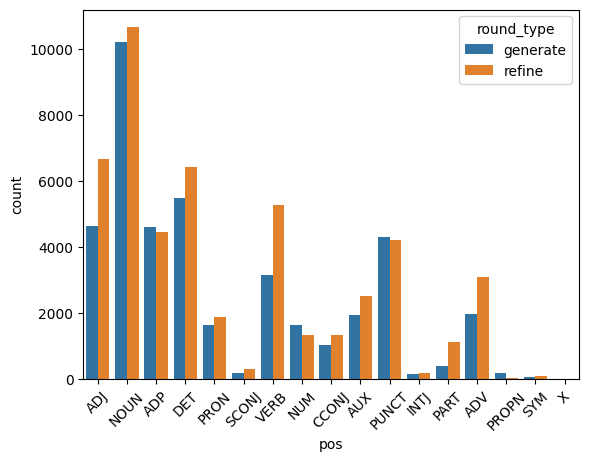

In [58]:
sns.countplot(data=dummy_df, x='pos', hue='round_type')
plt.xticks(rotation=45)